# Tarea Examen 2

Nombre: Román Tamez Vidal Tamayo Tamez

### Física Computacional 2025-2

Resuelva los siguientes ejercicios.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math as m

In [2]:
import matplotlib
# Para el formato de las gráficas
matplotlib.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
        "font.size": 12,
        "pgf.preamble": "\n".join([ # Aún más formato
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        ])
    }
)

### Problema 1
Se tiene un oscilador armónico en dos dimensiones ($xy$) en el que la fuerza está dada por $\vec{F} = -k \vec{r}$ y se tiene una fricción 

$$
\vec{f}_{\text{fric}} = 
\begin{cases}
-\gamma \vec{v} & \text{si } |\vec{v}| \leq 1 \\
-\mu v^2 \hat{v} & \text{si } |\vec{v}| > 1 \,,
\end{cases}
$$

donde $m = 1$, $k = 1$, $\gamma = 0.15$ y $\mu = 0.25$. Resuelva los siguientes ejercicios:

#### Inciso a)
Encuentre las ecuaciones de movimiento en coordenadas cartesianas. No es necesario resolver las ecuaciones.

Por Newton se tiene que
$$
m\frac{d^2\vec{r}}{dt^2} = \vec{F} + \vec{f}_{\text{fric}}\,.
$$

Notando que  $v = |\vec{v}| = \sqrt{v_x^2 + v_y^2} = \sqrt{\left(\frac{dx}{dt}\right)^2 + \left(\frac{dy}{dt}\right)^2} = v\hat{v}$, se separa la ecuación en términos de cada componente.

$$
m \frac{d^2 x}{dt^2} = -kx + 
\begin{cases}
-\gamma \frac{dx}{dt} & \text{si } v \leq 1 \\
-\mu v \frac{dx}{dt} & \text{si } v > 1
\end{cases}
$$

$$
m\frac{d^2 y}{dt^2} = -ky + 
\begin{cases}
-\gamma \frac{dy}{dt} & \text{si } v \leq 1 \\
-\mu v \frac{dy}{dt} & \text{si } v > 1
\end{cases}
$$

In [ ]:
constantes = [1.0, 1.0, 0.15, 0.25]
def edo_1(t, sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m, k, gma, mu = consts

    v = (vx**2 + vy**2)*0.5
    if v <= 1:
        fric = [-gma*vx, -gma*vy]
    else: 
        fric = [-mu*v*vx, -mu*v*vx]

    dvxdt = (-k*x + fric[0])/m
    dvydt = (-k*y + fric[1])/m
    return np.array([vx, vy, dvxdt, dvydt])

#### Inciso b)
Utilice el método de Runge-Kutta de 4to orden para encontrar la solución a las ecuaciones de movimiento con condiciones iniciales $\vec{r}_0 = (0, 1)$ y $\vec{v}_0 = (2\cos\theta, 2\sin\theta)$, donde $\theta = \frac{n\pi}{6}$ con $n = 0, 1, 2, \ldots, 11$.

In [4]:
def integrar_RK4(f, ts, sol0):
    """
    Integra la EDO usando el método de Runge-Kutta de cuarto orden.
    f: función que define el sistema
    ts: tiempos
    sol0: condiciones iniciales
    """
    sols = np.zeros((len(ts), len(sol0)))
    sols[0] = sol0
    h = abs(ts[1]-ts[0])

    for i in range(1, len(ts)):
        t, sol = ts[i-1], sols[i-1]
        # Kuttas
        k1 = f(t        , sol)
        k2 = f(t + 0.5*h, sol + 0.5*h*k1)
        k3 = f(t + 0.5*h, sol + 0.5*h*k2)
        k4 = f(t +     h, sol +     h*k3)
        # Runges
        sols[i] = sol + h*f(t+h/2 ,sol + (h/6)*(k1+2*k2+2*k3+k4))

    return sols

In [40]:
# Condiciones iniciales
t0, tf = 0, 10  # Tiempo inicial y final
h = 0.01  # Paso de tiempo
ts = np.arange(t0, tf, h)

r = [0, 1] # x, y
vs = [[2*np.cos(n*np.pi/6), 2*np.sin(n*np.pi/6)] for n in range(12)] # vx, vy
sol0_all = [[r[0], r[1], v[0], v[1]] for v in vs] # x, y, vx, vy

In [41]:
sols_all = [integrar_RK4(edo_1, ts, sol0) for sol0 in sol0_all]

#### Inciso c)
Genere una función que calcule la energía para las distintas condiciones iniciales y detenga la simulación cuando ésta sea menor al 30\% de su valor inicial. Asegúrese de que el error en la trayectoria no tenga variaciones de más del 0.1\%.

In [ ]:
def energia(sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m, k = consts[0], consts[1]

    r = (x**2 + y**2)*0.5
    v = (vx**2 + vy**2)*0.5
    T = 0.5 * m *  v**2
    U = 0.5 * k * r**2
    return  T - U

In [76]:
def simulacion(edo,ts, sol0, goal=0.3):
    '''
    Simula hasta que la energía del sistema sea 
    30% la inicial
    '''
    # Inicialización
    sols = np.zeros((len(ts), len(sol0)))
    enes = np.zeros(len(ts))

    paso_t = [ts[0], ts[1]]
    paso_sol = integrar_RK4(edo, paso_t, sol0)
    sols[0], sols[1] = paso_sol[0], paso_sol[1]

    enes[0] = energia(paso_sol[0])
    ene_goal = enes[0]*goal     # Mucho ojo. Ojo cuidado!!!
    enes[1] = energia(paso_sol[1]) 
    
    i = 1
    while (enes[i] > ene_goal):
        paso_t = [ts[i], ts[i+1]]
        paso_sol = integrar_RK4(edo, paso_t, sols[i])
        sols[i+1] = paso_sol[1]
        enes[i+1] = energia(sols[i+1]) 

        i += 1

    return ts[:i+1], sols[:i+1], enes[:i+1]


def obtener_tf(edo_func, args, sols0, h = 0.1 ,t0=0, goal = 0.3):
    """
    Simula el sistema para cada una de las condiciones iniciales
    hasta que se llega a una energía 'goal' veces menor a la inicial
    """
    edo = lambda t, sol: edo_func(t, sol, args)
    N_sols = len(sols0)
    
    # Inicializacion
    tf = t0 + 100
    ts = np.arange(t0, tf, h)
    data_all = ['']*N_sols

    for i in range(N_sols):
        data_all[i] = simulacion(edo, ts, sols0[i], goal)

    return data_all

El método RK4 tiene un error de $h^5$. Para el cálculo de las energías se tomará $h=0.01$, por lo que podemos asegurar que el error de las trayectorias es menor al 0.1\%.

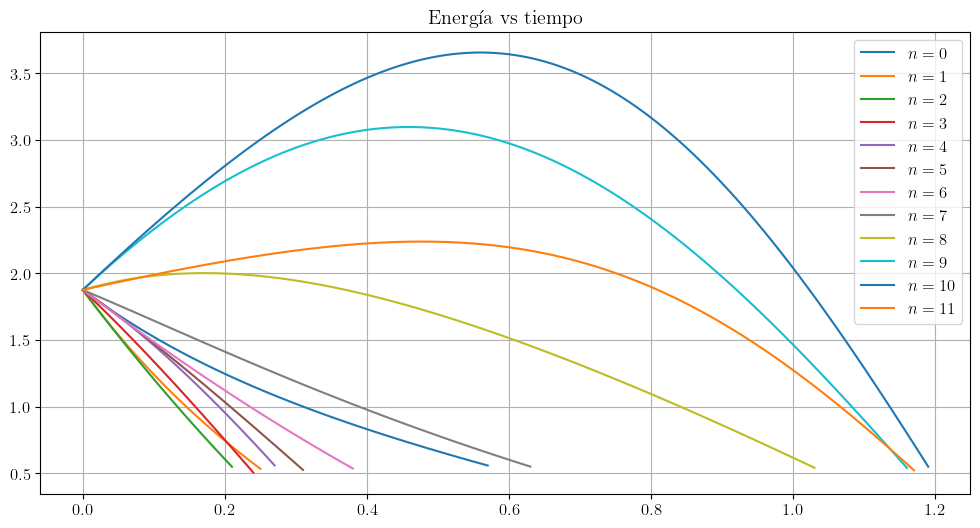

In [77]:
constantes = [1.0, 1.0, 0.15, 0.25]
data_all = obtener_tf(edo_1, constantes, sol0_all, 0.01)

# Graficas
plt.figure(figsize=(12,6))
plt.title("Energía vs tiempo")
for i in range(len(data_all)):
    tiempos, soluciones, energias = data_all[i]

    plt.plot(tiempos, energias, label=r"$n={}$".format(i))
    
plt.grid(), plt.legend()
plt.show()

#### Inciso d)
Dibuje las gráficas del momento angular para los casos del inciso (b).

In [ ]:
def L_angular(sol, consts = constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m = consts[0]
    return (x*vy - y*vx)*m
    
def func_arreglo(ts, func_args, func ,consts = constantes):
    arr = np.zeros_like(ts)
    for i in range(len(ts)):
        arr[i] = func(func_args[i], consts)
    return arr

In [51]:
L_angulares_all = [func_arreglo(ts, sols, L_angular) for sols in sols_all]

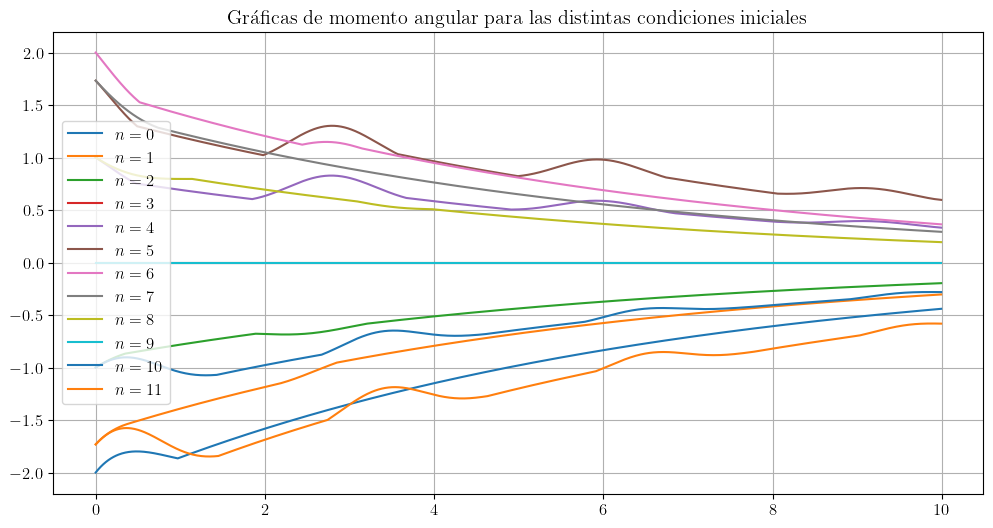

In [52]:
# Graficas
plt.figure(figsize=(12,6))
plt.title("Gráficas de momento angular para las distintas condiciones iniciales")
for i in range(len(L_angulares_all)):
    plt.plot(ts, L_angulares_all[i], label=r"$n={}$".format(i))
    
plt.grid(), plt.legend()
plt.show()


#### Inciso e)
Tome de manera arbitraria alguna condición inicial y dibuje el espacio fase $(p_x, x)$.

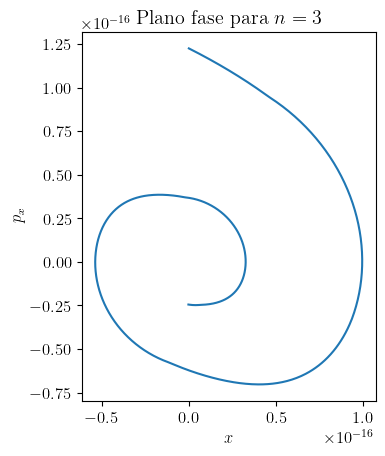

In [10]:
ind = np.random.randint(0,12)

x = sols_all[ind][:,0]
px = sols_all[ind][:,2] * constantes[0]

plt.plot(x,px)
plt.title(r'Plano fase para $n={}$'.format(ind))
plt.xlabel(r'$x$'),plt.ylabel(r'$p_x$'),
plt.gca().set_aspect('equal')
plt.show()

### Problema 2
Suponga que se tienen dos partículas de masa $m$ y que una de ellas se encuentra anclada en el origen. La fuerza entre ellas es de tipo resorte con fuerza $\vec{F} = -k\vec{r}$. Además, ambas partículas tienen carga $q > 0$ y por lo tanto también interactúan por fuerza de Coulomb.

***Nota:** No considere el caso relativista ni la generación de campos magnéticos producidos por el movimiento de las partículas.*

In [ ]:
constantes = [1.0, 1.0, 0.5, 0] #  [m, k, q, gma]
def edo_2(t, sol, consts=constantes):
    # sol = [x, y, vx, vy] donde vx = dx/dt y vy = dy/dt
    x, y, vx, vy = sol
    m, k, q, gma = consts

    r3_2 = (x**2 + y**2)**1.5

    dvxdt = (-k*x + (q**2) * x / r3_2 - gma*vx)/m
    dvydt = (-k*y + (q**2) * y / r3_2 - gma*vy)/m
    return np.array([vx, vy, dvxdt, dvydt])

def energia_2(sol, consts=constantes):
    x, y, vx, vy = sol
    m, k, q, lmd = consts

    r = (x**2 + y**2)**0.5
    v2 = vx**2 + vy**2
    return 0.5*m*v2 - (0.5*k*r**2 + (q**0.5)/r)

def pot_eff(sol, consts=constantes):
    x, y, vx, vy = sol
    m, k, q, lmd = consts

    r2 = x**2 + y**2
    U_cent = 0.5 * L_angular(sol, constantes)**2/r
    U_hc = -(0.5*k*r2 + (q**0.5)/(r2**0.5))

    return U_cent + U_hc

def pot_eff_r(r,ci):
    m_ang = L_angular(ci)
    return (0.5*m_ang**2)/r**2 - 1/r

#### Inciso a)
Sin considerar la fricción, ¿el sistema puede tener órbitas cerradas? De ser así, encuentre algunas de estas órbitas o muestre que el sistema no puede tener este tipo de órbitas. (Apoye sus argumentos con algunas simulaciones).

E = -0.599
E = -0.404
E = -0.224
E = -0.004
E = 0.401


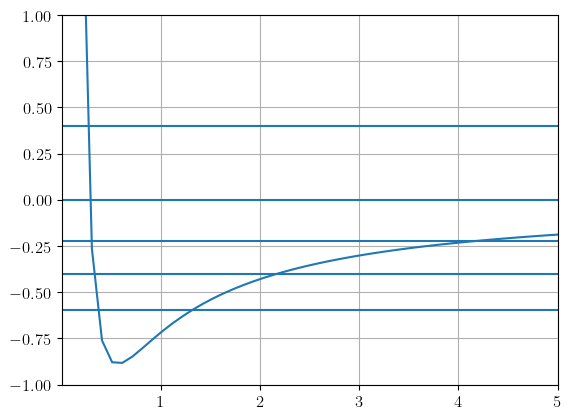

In [13]:
vxs = [0.5,0.8,1.0,1.2,1.5]
r = np.linspace(1e-8,5)
for vx in vxs:
    ci = np.array([0.75,0,vx,1])
    E = energia_2(ci)
    print("E = {:.3f}".format(E))
    plt.hlines(E,r[0],r[-1])

P_eff = func_arreglo(r, r, pot_eff_r, ci)

plt.plot(r,P_eff)
plt.xlim(r[0],r[-1]),plt.ylim(-1,1)
plt.grid()
plt.show()

Hay un mímino en el potencial efectivo y la energía total del sistema se conserva, por lo que se puede asegurar que sí hay orbitas estables.

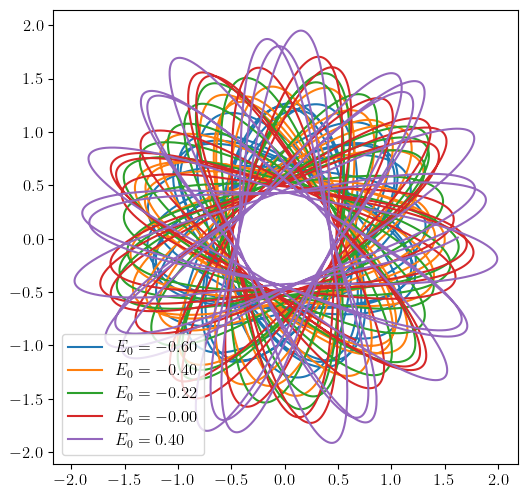

In [14]:
ts = np.arange(0,30*np.pi,0.003)
plt.figure(figsize=(6,6))
for vx in vxs:
    ci = np.array([0.75,0,vx,1])
    E = energia_2(ci)
    sols = integrar_RK4(edo_2, ts, ci)
    x , y = sols[:,0], sols[:,1]
    plt.plot(sols[:,0], sols[:,1],label=r'$E_0 = {:.2f}$'.format(E))
    
plt.legend(), plt.gca().set_aspect('equal')
plt.show()

#### Inciso b) 
Considerando fricción proporcional a la velocidad, ¿el sistema puede tener órbitas cerradas? De ser así, encuentre algunas de estas órbitas o muestre que el sistema no puede tener este tipo de órbitas. (Apoye sus argumentos con algunas simulaciones).

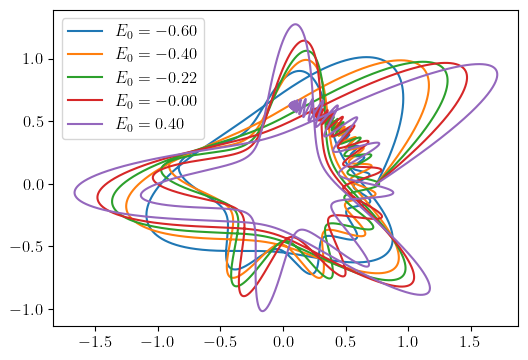

In [15]:
constantes = [1.0, 1.0, 0.5, 0.10]
plt.figure(figsize=(6,6))
for vx in vxs:
    ci = np.array([0.75,0,vx,1])
    E = energia_2(ci)
    sols = integrar_RK4(lambda t, sol: edo_2(t, sol, constantes), ts, ci)
    plt.plot(sols[:,0], sols[:,1],label=r'$E_0 = {:.2f}$'.format(E))

plt.legend(), plt.gca().set_aspect('equal')
plt.show()

La energía disminuye conforme pasa el tiempo, por lo que eventualmente se para el sistema.

### Problema 3
Se tiene una partícula de masa $m = 1$ en un campo gravitacional $\vec{g} = -9.8 \hat{j}$ en una caja como se muestra en la Figura 1 con $L = 10$ m y $d = 3$ m. Realice este problema con valores de $\alpha = \frac{\pi}{6}$ y $\alpha = \frac{\pi}{10}$.

In [78]:
import scipy.integrate as sp

In [97]:
constantes = [1.0, 9.8, 0.15]
def edo_3(t , sol, consts = constantes):
    x, y, vx, vy = sol
    # consts = [m, k, gma, mu]
    m, g, gma = consts
    # x_v = [x,y,vx,vy]

    dvxdt = -gma*vx
    dvydt = -g - gma*vy
    return np.array([vx,vy,dvxdt,dvydt])

def suelo(t,sol, consts = constantes):
    return sol[1]

def suelo_techo(t,sol, consts = constantes):
    return sol[1]

In [93]:
def caida_con_rebote(ci , t_final , consts=constantes, reb_tot=10):
    x , y , reb = np.array([]) , np.array([]) , 0 
    while reb < reb_tot:
        x_v = sp.solve_ivp(edo_3,(0,t_final),ci,dense_output=True,events=suelo,args=(consts,))
        t_reb = x_v.t_events[0][-1]
        t = np.arange(0,t_reb,0.05)
        x_n , y_n , vx_n , vy_n = x_v.sol(t)
        x , y  = np.concatenate((x,x_n)) , np.concatenate((y,y_n)) 
        n_ci = x_v.sol(t_reb)
        n_ci[3] = -n_ci[3]
        t_final , ci = 2.1*t_reb , n_ci
        reb += 1
    x , y  = np.concatenate((x,np.array([n_ci[0]]))) , np.concatenate((y,np.array([n_ci[1]]))) 
    return x , y

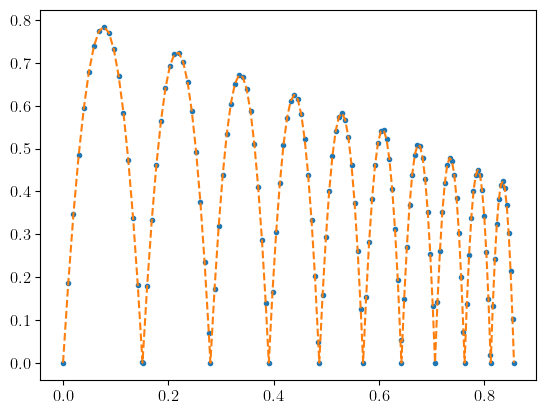

In [94]:
tf = 1
ci = [0.0,0.0,0.2,4.0]

x , y = caida_con_rebote(ci,tf, constantes)
plt.plot(x,y,'.')
plt.plot(x,y,'--')
plt.show()

In [98]:
def caida_con_rebote2(ci , t_final , consts=constantes, reb_tot=10):
    x , y , reb = np.array([]) , np.array([]) , 0 
    while reb < reb_tot:
        x_v = sp.solve_ivp(edo_3,(0,t_final),ci,dense_output=True,events=suelo_techo,args=(consts,))
        t_reb = x_v.t_events[0][-1]
        t = np.arange(0,t_reb,0.05)
        x_n , y_n , vx_n , vy_n = x_v.sol(t)
        x , y  = np.concatenate((x,x_n)) , np.concatenate((y,y_n)) 
        n_ci = x_v.sol(t_reb)
        n_ci[3] = -n_ci[3]
        t_final , ci = 2.1*t_reb , n_ci
        reb += 1
    x , y  = np.concatenate((x,np.array([n_ci[0]]))) , np.concatenate((y,np.array([n_ci[1]]))) 
    return x , y

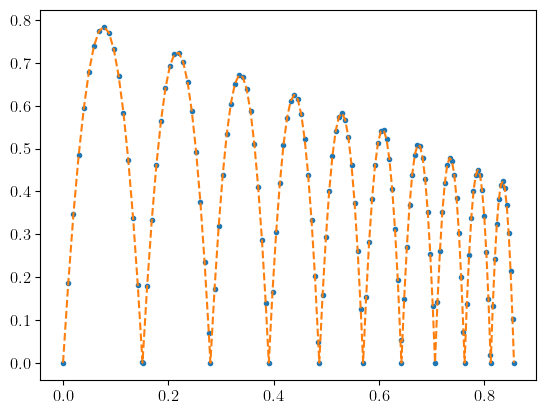

In [99]:
x , y = caida_con_rebote2(ci,tf, constantes)
plt.plot(x,y,'.')
plt.plot(x,y,'--')
plt.show()

#### Inciso a)
Realice una simulación con condición inicial tal que la posición inicial está sobre la rampa a un tercio de la distancia entre la pared vertical izquierda y el vértice inferior de la caja, y se dispara con velocidad $|\vec{v}| = 1$ hacia la derecha con ángulos sobre la horizontal $\alpha$, $2\alpha$ y $3\alpha$. La simulación debe incluir al menos 20 rebotes.

#### Inciso b)
Introduzca algún modelo de fricción y compare las trayectorias con el inciso anterior.

#### Inciso c)
Realice los ejercicios en los incisos (a) y (b) pero ahora con $|\vec{v}| = 25$ y $|\vec{v}| = 60$. Describa las similitudes y diferencias entre las distintas simulaciones.

#### Inciso d) 
Dibuje el espacio fase $(p_x, x)$ y $(p_y, y)$ cuando no hay fricción y la partícula es lanzada hacia la derecha a un ángulo $\alpha$ y vertical hacia arriba. Considere el número necesario de rebotes para barrer el espacio fase representativamente.